### Naman Malik
### 101916072

### Imports and Data Read

In [1]:
!pip install pmdarima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from IPython.display import clear_output
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from math import sqrt
import pandas as pd
import numpy as np
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
df = pd.read_excel("DATASET.xlsx")
df.head()

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


,Unnamed: 0,year,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
0,Sec_1,1,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.52
1,NaN,2,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.62
2,NaN,3,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.68
3,NaN,4,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.78
4,NaN,5,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.80


### Pre Processing

In [3]:
# Dropping section 92 as it has only 9 years data
df = df.drop([910, 911, 912, 913, 914, 915, 916, 917, 918])

In [4]:
# Replacing empty cells with zero
df.fillna(0, inplace=True)

In [5]:
# Formatting date column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df['year'] = pd.to_datetime([f"01-01-{date}" for date in df['year']])
df.head(15)
df.to_csv('cleaned.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
df = pd.read_csv('cleaned.csv',index_col='year')
df.head()

,Para-1,Para-2,Para-3,Para-4,Para-5,Para-6,Para-7,Para-8,Para-9,Para-10,Para-11,Para-12,Para-13
year,,,,,,,,,,,,,
2001-01-01,324.0,354.5,17.0,0.0,3,117,2600,400,0.0,0.0,0.0,0,1.52
2002-01-01,324.0,161.1,18.2,0.0,4,106,5950,1190,0.0,3.4,0.0,0,1.62
2003-01-01,324.0,170.7,18.5,0.0,4,110,5950,1190,0.0,21.3,0.0,4,1.68
2004-01-01,324.0,223.9,18.9,0.0,3,110,6150,1340,0.0,21.3,0.0,5,1.78
2005-01-01,324.0,228.2,18.4,0.0,2,113,6340,1450,0.0,23.9,0.0,7,1.80


### Model Training and Prediction

In [7]:
# Arima Predict Function

def arima_predict(data,parameter,bestModel):
    train_data = data.iloc[0:-1]
    test_data = data.iloc[-1:]
    model =  ARIMA(train_data[parameter],order=bestModel)
    model = model.fit()
    start = len(train_data)
    end = len(train_data)+len(test_data)-1
    pred = model.predict(start=start,end=end,type='levels')
    return pred

In [8]:
parameters = []
predicted_combined = []
actual_combined = []
predicted = {}
actual = {}

for i in range(9,14):
  parameters.append(f"Para-{i}")
  predicted[f"Para-{i}"]=[]
  actual[f"Para-{i}"]=[]

for i in range(100):
    sectionData = df.iloc[i*10:(i*10)+10,:]
    for parameter in parameters:
        stepwise_fit = auto_arima(sectionData[parameter],trace=True,suppress_warnings=True)
        bestModel =  stepwise_fit.get_params().get("order")
        predictedValue = arima_predict(sectionData,parameter,bestModel)
        actualValue = sectionData.iloc[-1:][parameter]
        if len(predictedValue)>0:
            predicted_combined.append(predictedValue[0])
            actual_combined.append(actualValue[0])
            predicted[parameter].append(predictedValue)
            actual[parameter].append(actualValue)
        clear_output(wait=False)

clear_output(wait=False)

In [9]:
for j in range(9,14):
  pMeter = f"Para-{j}"
  for i in range(len(actual[pMeter])):
    actual[pMeter][i] = actual[pMeter][i].to_numpy()[0]

for j in range(9,14):
  pMeter = f"Para-{j}"
  for i in range(len(predicted[pMeter])):
    predicted[pMeter][i] = predicted[pMeter][i].to_numpy()[0]

In [10]:
rmse = sqrt(mean_squared_error(predicted_combined,actual_combined))
print("Root Mean Square Error = ",rmse)

Root Mean Square Error =  45.83683939079716


###Plots

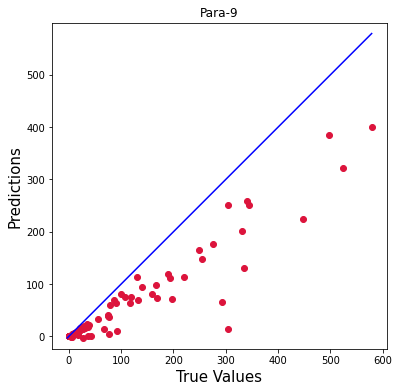

In [11]:
pMeter = "Para-9"
plt.figure(figsize=(6,6))
true_value = actual[pMeter]
predicted_value = predicted[pMeter]
plt.scatter(true_value, predicted_value, c='crimson')
p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title(pMeter)
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()
print()

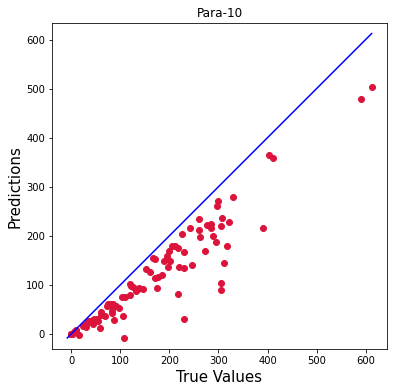

In [12]:
pMeter = "Para-10"
plt.figure(figsize=(6,6))
true_value = actual[pMeter]
predicted_value = predicted[pMeter]
plt.scatter(true_value, predicted_value, c='crimson')
p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title(pMeter)
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()
print()

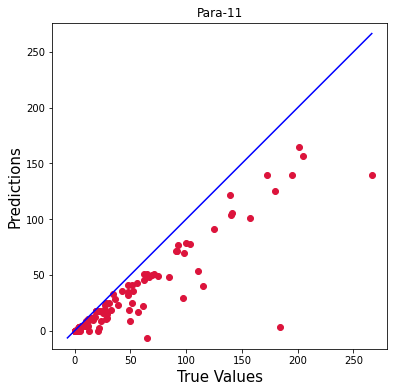

In [13]:
pMeter = "Para-11"
plt.figure(figsize=(6,6))
true_value = actual[pMeter]
predicted_value = predicted[pMeter]
plt.scatter(true_value, predicted_value, c='crimson')
p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title(pMeter)
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()
print()

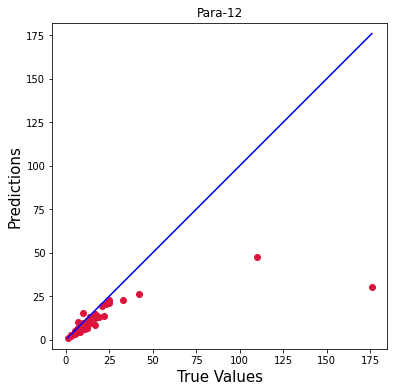

In [14]:
pMeter = "Para-12"
plt.figure(figsize=(6,6))
true_value = actual[pMeter]
predicted_value = predicted[pMeter]
plt.scatter(true_value, predicted_value, c='crimson')
p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title(pMeter)
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()
print()

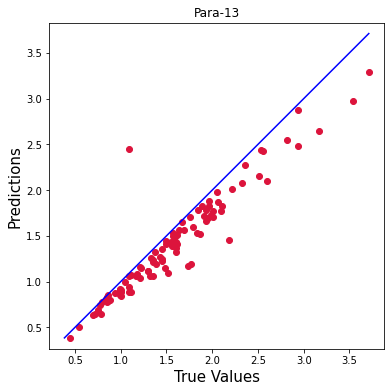

In [15]:
pMeter = "Para-13"
plt.figure(figsize=(6,6))
true_value = actual[pMeter]
predicted_value = predicted[pMeter]
plt.scatter(true_value, predicted_value, c='crimson')
p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title(pMeter)
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()
print()

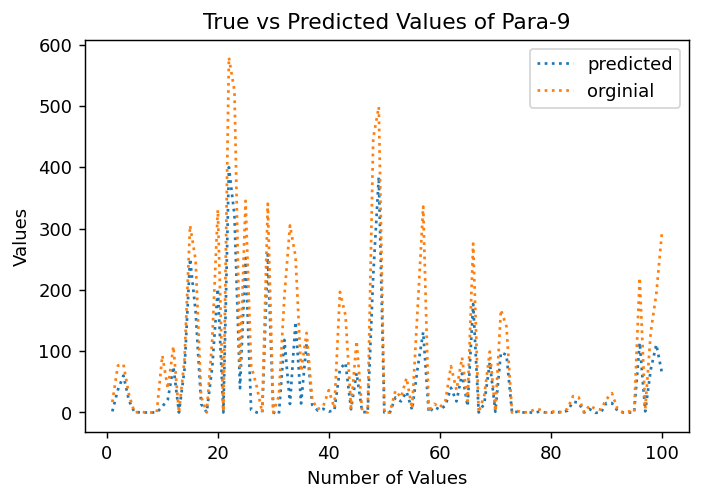

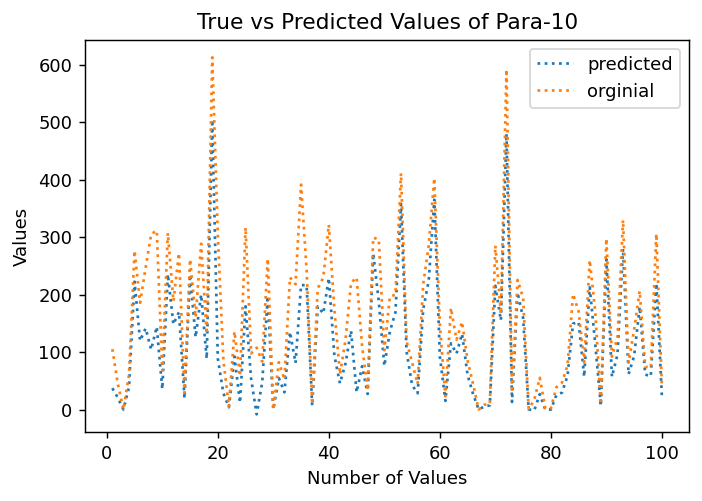

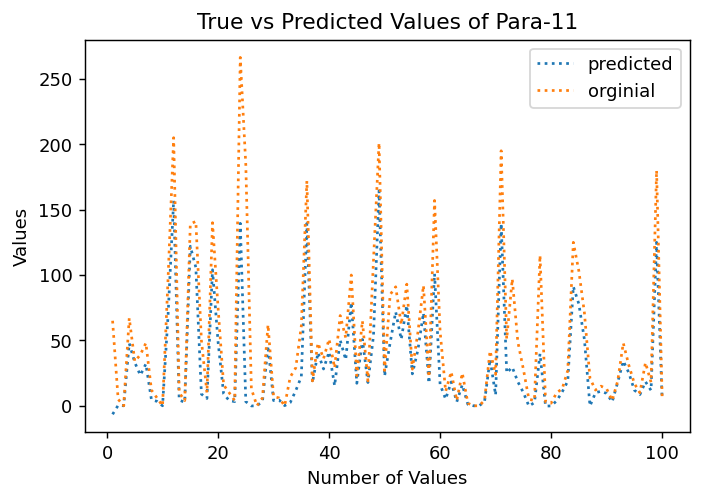

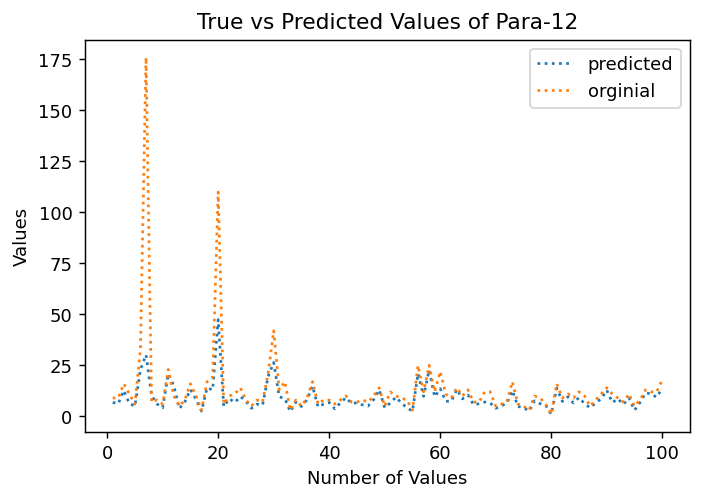

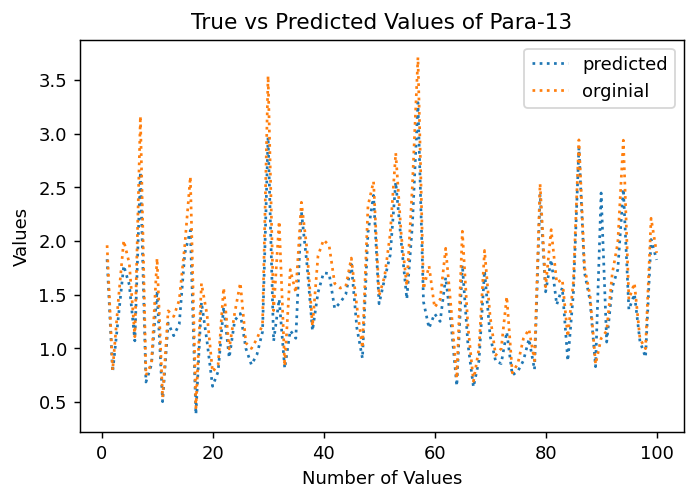

In [18]:

for i in range(9,14):
  pMeter = f"Para-{i}"
  figure(figsize=(6, 4), dpi=130)
  true_value = actual[pMeter]
  predicted_value = predicted[pMeter]
  x_value = []
  for i in range(len(true_value)):
    x_value.append(i+1)
  plt.plot(x_value,predicted_value, linestyle = 'dotted', label = 'predicted')
  plt.plot(x_value,true_value, linestyle = 'dotted', label = 'orginial')
  plt.xlabel('Number of Values')
  plt.ylabel('Values')
  plt.title(f'True vs Predicted Values of {pMeter}')
  plt.legend(loc = 'upper right')
  print("\n")